In [131]:
import numpy as np
from tqdm import tqdm
from collections import defaultdict
import json
import networkx as nx
import pandas as pd
from ast import literal_eval
from networkx.readwrite import json_graph
import matplotlib.pyplot as plt


In [132]:
def read_json_file(filename):
    with open(filename) as f:
        js_graph = json.load(f)
    return json_graph.node_link_graph(js_graph)

In [133]:
G = read_json_file('./data/graph.json')

In [134]:
field_list = []

def remove_node_if_no_field(author):
    try:
        field = G.nodes[author]['top_field']
        if field == 'nan':
            G.remove_node(author)
        else:
            field_list.append(field)
    except KeyError:
        G.remove_node(author)

authors = list(G.nodes)
for a in authors:
    remove_node_if_no_field(a)

In [135]:
n = len(G.nodes)
print(n)

5652


In [136]:
print(G.nodes[83401236]['top_field'])
print(list(G.adj[83401236]))

Geography
[]


In [137]:
def edge_same_top_field(edge, graph):
    field_a = graph.nodes[edge[0]]['top_field']
    field_b = graph.nodes[edge[1]]['top_field']
    return field_a == field_b



In [138]:
top_field_fraq_list = [edge_same_top_field(edge, G) for edge in list(G.edges)]

In [139]:
top_field_fraq = np.mean(top_field_fraq_list)

In [140]:
def randomize_field_get_mean(graph):
    for author, field in zip(list(graph.nodes), np.random.permutation(field_list)):
        graph.nodes[author]['top_field'] = field

    top_field_fraq = [edge_same_top_field(edge, graph) for edge in list(graph.edges)]

    return np.mean(top_field_fraq)

results = []
N_repeat = 500
graph_copy = G.copy()

for i in tqdm(range(N_repeat)):
    results.append(randomize_field_get_mean(graph_copy))

100%|██████████| 500/500 [00:11<00:00, 43.33it/s]


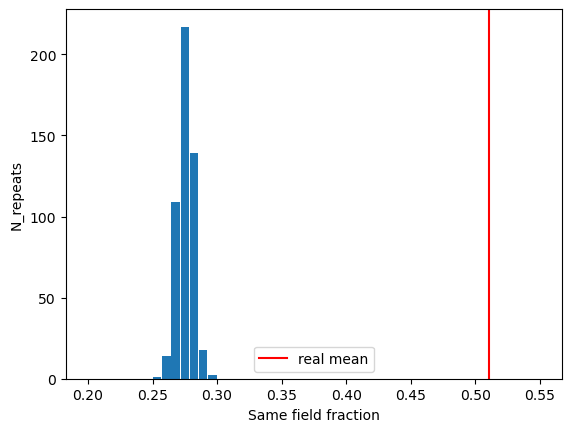

In [141]:
bins = np.linspace(0.2, 0.55, 50)
hist, edges = np.histogram(results, bins=bins)
x = (edges[1:] + edges[:-1])/2
width = bins[1] - bins[0]

fig, axs = plt.subplots()
axs.bar(x, hist, width=width*0.9)

axs.set_xlabel('Same field fraction')
axs.set_ylabel('N_repeats')
axs.axline((top_field_fraq, 0), (top_field_fraq, max(results)), color='red', label='real mean')
axs.legend()

In [190]:
fields_unique = np.unique(field_list)
fields_unique_n = len(fields_unique)

field_index = {}

for i in range(fields_unique_n): # Use this index for matrix
    field_index[fields_unique[i]] = i

degree_max = np.max([t[1] for t in list(G.degree)])
print(degree_max)

field_matrix = np.zeros((fields_unique_n-1, fields_unique_n-1)) # -1 to avoid the nan which is included in fields unique
degree_matrix = np.zeros((44, 44))

for edge in list(G.edges): # For all edges, increment related matrix values

    field_a = G.nodes[edge[0]]['top_field']
    field_b = G.nodes[edge[1]]['top_field']

    deg_a = G.degree[edge[0]]
    deg_b = G.degree[edge[1]]

    degree_matrix[deg_a, deg_b] += 1
    degree_matrix[deg_b, deg_a] += 1

    try:
        field_a_index = field_index[field_a]
        field_b_index = field_index[field_b]

        field_matrix[field_a_index, field_b_index] += 1
        field_matrix[field_b_index, field_a_index] += 1

    except: # Some fields are nan, do nothing
        pass

field_matrix = field_matrix.astype(int)
field_matrix = np.divide(field_matrix, np.sum(field_matrix))

degree_matrix = np.divide(degree_matrix, np.sum(degree_matrix))



43


In [193]:
r_field = (np.trace(field_matrix) - np.sum(field_matrix**2))/(1-np.sum(field_matrix**2))
r_degree = (np.trace(degree_matrix) - np.sum(degree_matrix**2))/(1-np.sum(degree_matrix**2))

In [194]:
print("assortativity coefficient for field", r_field)

print("assortativity coefficient for degree", r_degree)


print(G.degree[83401236])


assortativity coefficient for field 0.43215723604432005
assortativity coefficient for degree 0.4732615784444879
0


In [176]:
print(fields_unique)
print((field_matrix*100).astype(int))

['Art' 'Biology' 'Business' 'Chemistry' 'Computer Science' 'Economics'
 'Engineering' 'Environmental Science' 'Geography' 'Geology' 'History'
 'Materials Science' 'Mathematics' 'Medicine' 'Philosophy' 'Physics'
 'Political Science' 'Psychology' 'Sociology' 'nan']
[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 36  1  0  0  0  0  0  0  0  3  0  1  2  1  1]
 [ 0  0  0  0  1  1  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0

[(1678244, 3), (2950213, 15), (8179569, 2), (143906534, 3), (1678397, 1), (144629886, 1), (1678460, 5), (1703601, 5), (1760810, 5), (1767493, 5), (1776476, 25), (2023275, 5), (1678535, 1), (1389920075, 8), (1678622, 3), (1709005, 3), (9571638, 3), (143640165, 3), (1680082, 7), (1712423, 36), (1732913, 7), (9602006, 7), (40016674, 8), (40052301, 7), (143604617, 16), (144576794, 6), (1680100, 2), (39775087, 1), (1489125592, 1), (1680158, 4), (1690892, 7), (1947710, 4), (145164644, 4), (2068335654, 4), (1681836, 2), (1697703, 5), (1829115, 1), (1844852, 12), (1890113, 0), (2159730, 4), (2192921, 4), (2670187, 5), (2692274, 5), (3106046, 5), (32861190, 5), (34827715, 7), (39556143, 1), (39710593, 1), (39887691, 2), (143667081, 5), (145280613, 16), (145301662, 4), (1403171029, 18), (1406761192, 4), (1453594539, 4), (1666605207, 1), (2033632163, 2), (2109208547, 2), (1680327, 3), (2046500, 3), (1388775854, 4), (1389957009, 5), (1680329, 0), (1680697, 1), (1724322, 1), (1680870, 3), (2117571,